# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 10 (Interpreting Machine Learning Models )

**Harvard University**<br>
**Summer 2021**<br>
**Instructor:** Kevin Rader<br>


---

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Interpreting Models </li> 
<li> LIME </li> 
<li> Randomization Testing </li> 
    

## Learning Goals

This Jupyter notebook accompanies Lecture 10. By the end of this notebook, you should be able to:

- Interpret the results of machine learning models using several methods. 
- Use LIME and ELI5 packages.
- Investigate the use of randomization testing for AB testing data


In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt

#from sklearn.linear_model import LogisticRegression
#from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import ensemble

# Here are the decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# sns.set(style="ticks")
# %matplotlib inline

## Part 1: Data Wrangling

Today, we will be using the `Heart.csv` data set we've seen many times before.  We are trying to perform analyses to predict `AHD` frmo the other predictors.  We start by reading in the data, loo

In [2]:
heart_df = pd.read_csv('../data/Heart.csv')

In [3]:
print(heart_df.shape)
heart_df.head()

(303, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [4]:
heart_df.describe()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000
mean,152.000000,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241
std,87.612784,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,76.500000,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,152.000000,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,227.500000,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,303.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


In [5]:
X = heart_df[['Age','Sex','ChestPain','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope','Ca','Thal']]
y = 1*(heart_df['AHD']=='Yes')

In [6]:
X = X.assign(ChestPain=X['ChestPain'].astype('category').cat.codes)
X = X.assign(Thal=X['Thal'].astype('category').cat.codes)

In [7]:
X.describe()
X['Ca']=X['Ca'].fillna(0)

In [8]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(X.shape[0]), train_size=0.80)

X_train = X.iloc[itrain, :]
X_test = X.iloc[itest, :]
y_train = y.iloc[itrain]
y_test = y.iloc[itest]


In [9]:
heart_df['ChestPain'].astype('category').dtypes

CategoricalDtype(categories=['asymptomatic', 'nonanginal', 'nontypical', 'typical'], ordered=False)

In [10]:
X

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
0,63,1,3,145,233,1,2,150,0,2.3,3,0.0,0
1,67,1,0,160,286,0,2,108,1,1.5,2,3.0,1
2,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2
3,37,1,1,130,250,0,0,187,0,3.5,3,0.0,1
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,3,110,264,0,0,132,0,1.2,2,0.0,2
299,68,1,0,144,193,1,0,141,0,3.4,2,2.0,2
300,57,1,0,130,131,0,0,115,1,1.2,2,1.0,2
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,1


**Q1.1**: How were the categorical variables handled?  How were missing values treated?  Were these wise choices?

*your answer here

---

## Part 2: Fitting Four Untuned ML Models

Start with 2 decision tree models and evaluate using AUC:

In [11]:
# fit a possibly underfit (depth = 3) decision tree classifier
dt3 = tree.DecisionTreeClassifier(max_depth = 3)
dt3.fit(X_train,y_train)

# fit an overfit (depth = 10) decision tree classifier
dt10 = tree.DecisionTreeClassifier(max_depth = 10)
dt10.fit(X_train,y_train)




DecisionTreeClassifier(max_depth=10)

In [12]:
# Evaluate using AUC

print("AUC on train for dt3:",sk.metrics.roc_auc_score(y_train,dt3.predict_proba(X_train)[:,1]))
print("AUC on test for dt3:",sk.metrics.roc_auc_score(y_test,dt3.predict_proba(X_test)[:,1]))

print("AUC on train for dt10:",sk.metrics.roc_auc_score(y_train,dt10.predict_proba(X_train)[:,1]))
print("AUC on test for dt10:",sk.metrics.roc_auc_score(y_test,dt10.predict_proba(X_test)[:,1]))



AUC on train for dt3: 0.9184375214909567
AUC on test for dt3: 0.8073593073593073
AUC on train for dt10: 1.0
AUC on test for dt10: 0.702922077922078


Now fit the two ensemble models: Rnadom Forest and Boosing:

In [13]:
# fit random forest and adaboost models

np.random.seed(109)
randomforest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=10)
randomforest.fit(X_train,y_train);

adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=1000,
    learning_rate=.8)
adaboost.fit(X_train,y_train);

In [14]:
# evaluating
print("AUC on train for randomforest:",sk.metrics.roc_auc_score(y_train,randomforest.predict_proba(X_train)[:,1]))
print("AUC on test for randomforest:",sk.metrics.roc_auc_score(y_test,randomforest.predict_proba(X_test)[:,1]))

print("AUC on train for adaboost:",sk.metrics.roc_auc_score(y_train,adaboost.predict_proba(X_train)[:,1]))
print("AUC on test for adaboost:",sk.metrics.roc_auc_score(y_test,adaboost.predict_proba(X_test)[:,1]))

AUC on train for randomforest: 1.0
AUC on test for randomforest: 0.886904761904762
AUC on train for adaboost: 1.0
AUC on test for adaboost: 0.8452380952380952


**Q2.1**: Which model performs best?  Which models are overfit?  How do you know?

*your answer here

## Part 3: Variable Importance

Fill in the blanks below to calculate the variable importances from the 4 untuned models above.

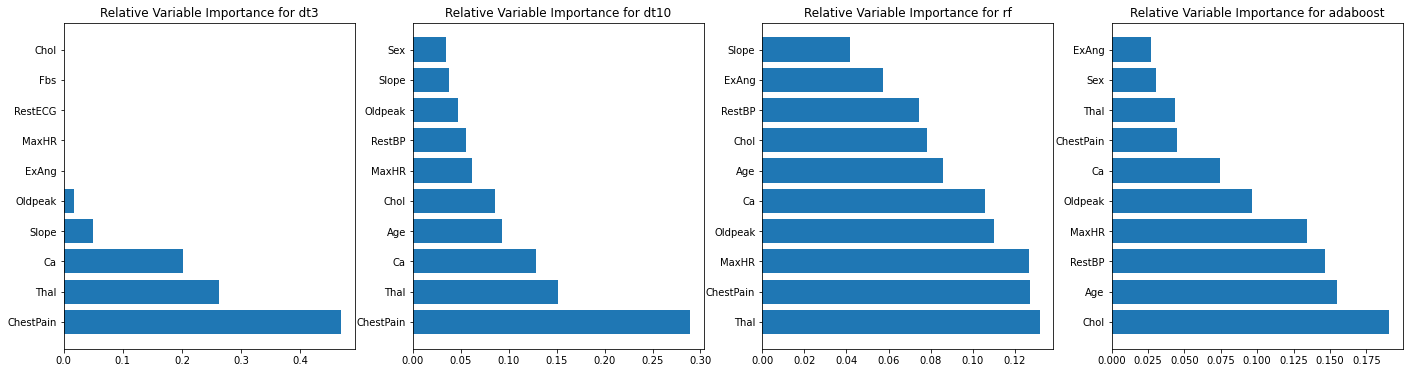

In [33]:
#Default Variable Importance

plt.figure(figsize=(24,6))
#plt.set_xticks()
#plt.set_xticklabels(X.columns)
num=10 

plt.subplot(1, 4, 1)
dt3_importances = dt3.feature_importances_
order = np.flip(np.argsort(dt3_importances))[0:num]
plt.barh(range(num),dt3_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for dt3")

plt.subplot(1, 4, 2)
dt10_importances = dt10.feature_importances_
order = np.flip(np.argsort(dt10_importances))[0:num]
plt.barh(range(num),dt10_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for dt10")

plt.subplot(1, 4, 3)
rf_importances = randomforest.feature_importances_
order = np.flip(np.argsort(rf_importances))[0:num]
plt.barh(range(num),rf_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for rf")

plt.subplot(1, 4, 4)
adaboost_importances = adaboost.feature_importances_
adaboost_importances = pd.Series(adaboost_importances).fillna(0)
order = np.flip(np.argsort(adaboost_importances))[0:num]
plt.barh(range(num),adaboost_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for adaboost");


**Q3.1**: How do these variable importance measures compare for these 4 models?  Which predictor is most important in general?  How is it related to `AHD`? 

*your answer here

---

## Part 4: Using Eli-5 

We will Explain It Like a 5 year old using `ELI-5` to calculate permutation importance.

In [34]:
!pip install eli5

In [35]:
import eli5

In [18]:
#permutation importance for the random forest
from eli5.sklearn import PermutationImportance

seed = 42

perm = PermutationImportance(randomforest,random_state=seed,n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X.columns.tolist())

Weight,Feature
0.0574 ± 0.0953,Ca
0.0557 ± 0.0751,ChestPain
0.0230 ± 0.0590,Oldpeak
0.0148 ± 0.0647,MaxHR
0.0115 ± 0.0719,Thal
0.0098 ± 0.0262,ExAng
0.0082 ± 0.0220,Fbs
0.0033 ± 0.0410,Sex
-0.0033 ± 0.0353,Slope
-0.0148 ± 0.0230,RestECG


**Q4.1**: Calculate and print out the permutation importances for the adaboost model

In [19]:
########
# your code below
########

perm = PermutationImportance(adaboost,random_state=seed,n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X.columns.tolist())

Weight,Feature
0.1016 ± 0.0652,Ca
0.0541 ± 0.0550,ChestPain
0.0410 ± 0.0930,Oldpeak
0.0410 ± 0.0302,ExAng
0.0262 ± 0.0832,MaxHR
0.0213 ± 0.0530,Sex
0.0164 ± 0.0464,Slope
0.0164 ± 0.0508,Chol
0.0148 ± 0.0272,Fbs
-0.0016 ± 0.0663,Thal


**Q4.2**: How do the permutation importance measures compare to the default variable importance in the random forest?  How does the boosted model compare to the random forest?

*your answer here*

---

## Part 5: Interpretation through Prediction Plots

We start by plotting hte predictions for all the observed data.


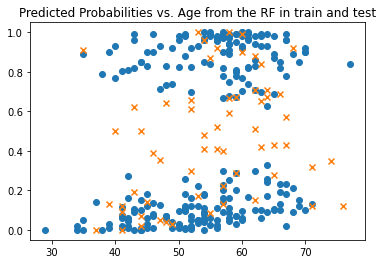

In [20]:
yhat_rf_train = randomforest.predict_proba(X_train)[:,1]
plt.scatter(X_train[['Age']],yhat_rf_train);
yhat_rf_test = randomforest.predict_proba(X_test)[:,1]
plt.scatter(X_test[['Age']],yhat_rf_test,marker='x');
plt.title("Predicted Probabilities vs. Age from the RF in train and test");

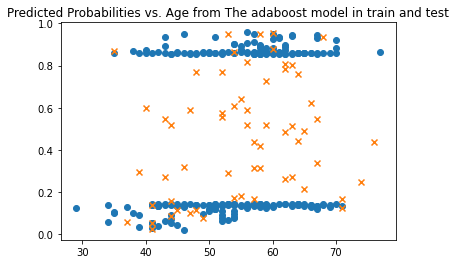

In [21]:
yhat_rf_train = adaboost.predict_proba(X_train)[:,1]
plt.scatter(X_train[['Age']],yhat_rf_train);
yhat_rf_test = adaboost.predict_proba(X_test)[:,1]
plt.scatter(X_test[['Age']],yhat_rf_test,marker='x');
plt.title("Predicted Probabilities vs. Age from The adaboost model in train and test");

**Q5.1** How do the random forest and boosted models compare in the interpretation of Age with AHD?  Which is more reliable?

*your answer here*

In [36]:
# Create the data frame of means to do the prediction
means1 = X_train.mean(axis = 0)
means_df = (means1.to_frame()).transpose()

# Do the prediction at all observed ages
Ages = np.arange(np.min(X['Age']),np.max(X['Age']))
means_df  = pd.concat([means_df]*Ages.size,ignore_index=True)
means_df['Age'] = Ages


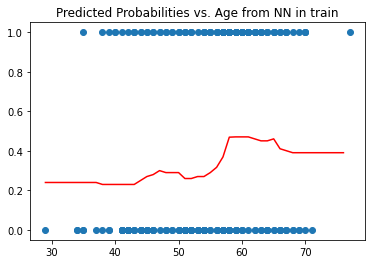

In [37]:
#plots at means
yhat_rf = randomforest.predict_proba(means_df)[:,1]
plt.scatter(X_train['Age'],y_train)
plt.plot(means_df['Age'],yhat_rf,color="red")
plt.title("Predicted Probabilities vs. Age from NN in train");

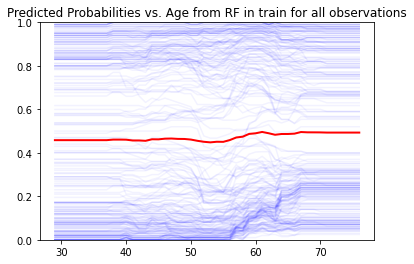

In [77]:
#Plots for all observations.  And then averaged
yhat_rfs = []
for i in range(0,X_train.shape[0]):
    obs = X_train.iloc[i,:].to_frame().transpose()
    obs_df  = pd.concat([obs]*Ages.size,ignore_index=True)
    obs_df['Age'] = Ages
    yhat_rf = randomforest.predict_proba(obs_df)[:,1]
    yhat_rfs.append(yhat_rf)
    plt.plot(obs_df['Age'],yhat_rf,color='blue',alpha=0.05)

plt.plot(obs_df['Age'],np.mean(yhat_rfs,axis=0),color='red',linewidth=2);
    
plt.ylim(0,1)
plt.title("Predicted Probabilities vs. Age from RF in train for all observations");

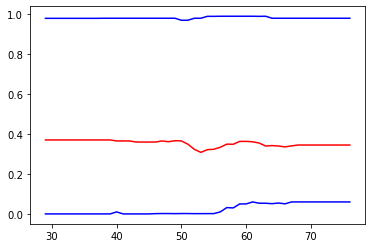

In [79]:
# plot the 90% prediction interval
plt.plot(obs_df['Age'],np.median(yhat_rfs,axis=0),color='red');
plt.plot(obs_df['Age'],np.quantile(yhat_rfs,q=.05,axis=0),color='blue');
plt.plot(obs_df['Age'],np.quantile(yhat_rfs,q=.95,axis=0),color='blue');


**Q5.2** Interpret the two plots above.  What is the difference in the interpretations?  Is there any evidence of interaction effects between Age and the other predictors?  How do you know?

*your answer here*

---

## Part 6: Using LIME

In [24]:
!pip install lime
import lime

     |████████████████████████████████| 275 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 169 kB 8.1 MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=17412a6e5eda6fa98a2d0f513f0338957f9b0ce3ab94256899bf277579d39d92
  Stored in directory: /home/chris/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [25]:
from lime.lime_tabular import LimeTabularExplainer
#explainer = LimeTabularExplainer(X_train)#class_names = [0,1])

explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns,
                                 class_names = [0,1],
                                 mode='classification')


In [26]:
idx = 42

exp = explainer.explain_instance(X_train.values[idx], 
                                 randomforest.predict_proba, 
                                 num_features = 13)#X_train.values[idx].size)

print('Observation #: %d' % idx)
print('Probability(AHD) =', randomforest.predict_proba(X_train)[idx][1])
print('True class: %s' % y_train[idx])

Observation #: 42
Probability(AHD) = 0.98
True class: 0


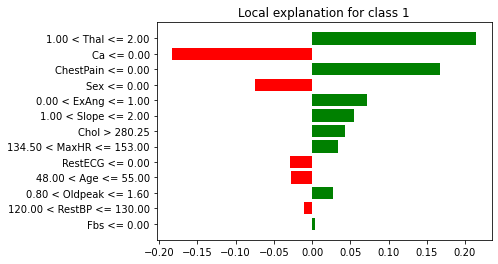

In [27]:
### Plot the results
# exp.as_list()
exp.as_pyplot_figure();

In [28]:
# change the observation number and see what changes.
idx = 109
exp = explainer.explain_instance(X_train.values[idx], 
                                 randomforest.predict_proba, 
                                 num_features = 13)

print('Observation #: %d' % idx)
print('Probability(AHD) =', randomforest.predict_proba(X_train)[idx][1])
print('True class: %s' % y_train[idx])

Observation #: 109
Probability(AHD) = 0.79125
True class: 1


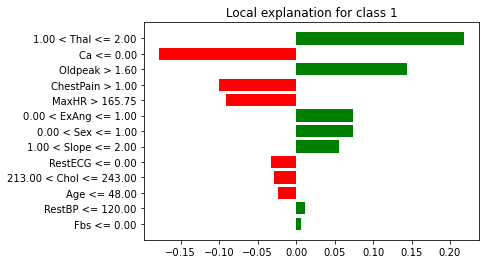

In [29]:
### Plot the results
# exp.as_list()
exp.as_pyplot_figure();

**Q6.1** Interpret the LIME results above.  Do they agree with the other interpretations for the random forest model seen so far?

*your answer here*

## Part 7: Randomization Testing

This part will investigate the power of performing a randomization test for comparing a response `y` between two groups (defined by `x`)

In [30]:
# Here we create the mythical data

diff = 0
n = 100
sd = 10

x = np.random.binomial(1,0.5,n)
y = np.random.normal(diff*x,sd,n)

df = pd.DataFrame(np.array([x,y]).T, columns = ["x","y"])
df.head()

,x,y
0,0.0,8.450309
1,1.0,-5.094827
2,1.0,3.762304
3,1.0,-1.722053
4,1.0,-2.206126


**Q7.1** Perform a permutation test (called a randomization test in this problem) on the data above.  What do you conclude?

In [31]:
replicates = 100
diffs = []
### your code here

for i in range(replicates):
    x_perm = np.random.choice(x,size=n,replace=False)
    
    diffs = np.append(diffs, np.mean(y[x_perm==1]) - np.mean(y[x_perm==0]))

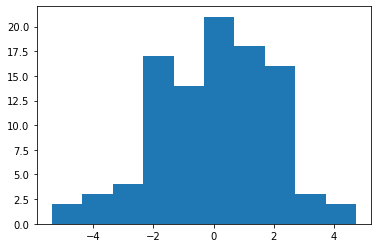

In [32]:
plt.hist(diffs);

*your answer here*

**Q7.2** Change the value of `diff` to reasonable values (start with 1). What do you conclude?

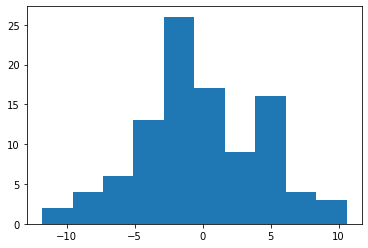

In [43]:
replicates = 100

### your code here

diff = 50
n = 100
sd = 10

x = np.random.binomial(1,0.5,n)
y = np.random.normal(diff*x,sd,n)

df = pd.DataFrame(np.array([x,y]).T, columns = ["x","y"])
df.head()

diffs = []
### your code here

for i in range(replicates):
    x_perm = np.random.choice(x,size=n,replace=False)
    
    diffs = np.append(diffs, np.mean(y[x_perm==1]) - np.mean(y[x_perm==0]))
 
plt.hist(diffs);

*your answer here*

The variance of the distribution increases with larger `diff`

**Q7.3** Replicate this data creation and permutation test 200 times (200 separate `experiments`) with `diff = 0`.  How often do you reject the null?  What happens as `diff` increases?

In [45]:
import scipy

def reject_null(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (0 < m-h) or (m+h < 0)

In [46]:
diff = 0
n = 100
sd = 10

x = np.random.binomial(1,0.5,n)
y = np.random.normal(diff*x,sd,n)

df = pd.DataFrame(np.array([x,y]).T, columns = ["x","y"])

replicates = 100
experiments = 200
results = []
### your code here

for i in range(experiments):
    for j in range(replicates):
        x_perm = np.random.choice(x,size=n,replace=False)

        diffs = np.append(diffs, np.mean(y[x_perm==1]) - np.mean(y[x_perm==0]))
    results.append(reject_null(diffs))

In [48]:
sum(results), sum(results)/len(results)

(27, 0.135)

*your answer here*